<a href="https://colab.research.google.com/github/palakagl/AI-in-Finance/blob/main/Stock_Price_Prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Long Short Term Memory 
## Stock Price Predicton 

Import the libraries

In [1]:
!pip install yfinance --upgrade --no-cache-dir

In [2]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os


import math
import yfinance as yf

import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Download the data from yahoo. 

In [4]:
df=web.DataReader('AAPL', 'yahoo', start='2012-01-01', end='2022-03-20')

df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.575922
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.643501
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.783871
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.917511
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.897020
...,...,...,...,...,...,...
2022-03-14,154.119995,150.100006,151.449997,150.619995,108732100.0,150.619995
2022-03-15,155.570007,150.380005,150.899994,155.089996,92964300.0,155.089996
2022-03-16,160.000000,154.460007,157.050003,159.589996,102300200.0,159.589996


In [5]:
df.shape

(2570, 6)

Visualize

Text(0, 0.5, 'Stock Price ($)')

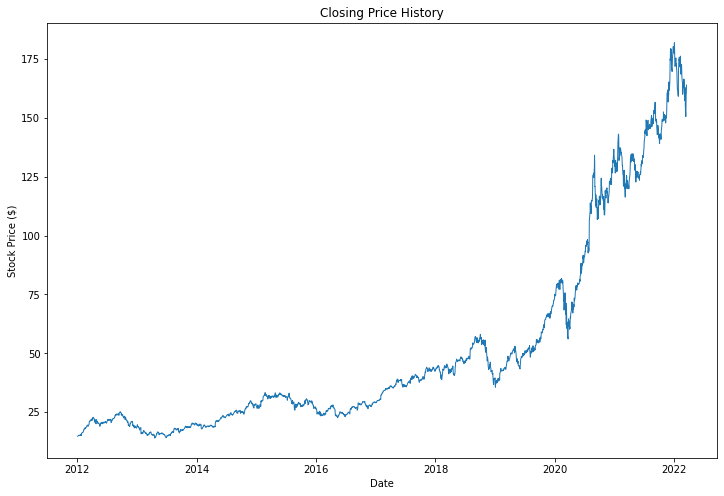

In [6]:
plt.figure(figsize=(12,8))
plt.title('Closing Price History')
plt.plot(df['Close'], lw=1)
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')

In [7]:
data=df.filter(['Close'])

Prepare the data

In [8]:
#convert to numpy array
#We are going to split the data into 80:20 ration for training and testing
train_pct=0.8  
dataset=data.values
train_data_len=math.ceil(len(dataset)*train_pct)

In [9]:
dataset

array([[ 14.6867857 ],
       [ 14.76571369],
       [ 14.92964268],
       ...,
       [159.58999634],
       [160.61999512],
       [163.97999573]])

In [10]:
dataset.shape

(2570, 1)

In [11]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

In [12]:
scaled_data

array([[0.00439887],
       [0.00486851],
       [0.00584391],
       ...,
       [0.86659725],
       [0.87272592],
       [0.89271849]])

Time Period to predict the Stock price

In [13]:
n_period=60
week = 5
#training dataset
train_data=scaled_data[0:train_data_len]
x_train=[]
y_train=[]

for i in range(n_period, len(train_data)):
    x_train.append(train_data[i-n_period:i,0])
    y_train.append(train_data[i,0])
   #y_train.append(train_data[i+week:-week,0])

In [14]:
x_train[0:2]

[array([0.00439887, 0.00486851, 0.00584391, 0.00677256, 0.00663019,
        0.00695107, 0.00680444, 0.00655793, 0.00622217, 0.00726133,
        0.00819848, 0.00790947, 0.0063263 , 0.00783722, 0.00634968,
        0.01192796, 0.01149658, 0.01205972, 0.01327737, 0.01401476,
        0.01395314, 0.01372576, 0.01469479, 0.01560643, 0.01663922,
        0.01830739, 0.02181161, 0.02186474, 0.02381555, 0.02527333,
        0.0227679 , 0.02373267, 0.02371354, 0.02641875, 0.02603411,
        0.026746  , 0.02802528, 0.02873719, 0.03078787, 0.03228178,
        0.03271317, 0.03286405, 0.03030973, 0.02969346, 0.02978484,
        0.03218616, 0.03286193, 0.03431335, 0.03773469, 0.04229932,
        0.04144504, 0.04144716, 0.04474738, 0.04578017, 0.04504489,
        0.04437338, 0.04367423, 0.04599691, 0.04759072, 0.04825798]),
 array([0.00486851, 0.00584391, 0.00677256, 0.00663019, 0.00695107,
        0.00680444, 0.00655793, 0.00622217, 0.00726133, 0.00819848,
        0.00790947, 0.0063263 , 0.00783722, 0.

In [15]:
y_train[0:2]

[0.04660893460974819, 0.04441800167645807]

In [16]:
#Convert numpy array
x_train, y_train=np.array(x_train), np.array(y_train)

In [17]:
x_train.shape

(1996, 60)

In [18]:
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape

(1996, 60, 1)

Training the model with Adam optimization (It is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.) 
For Loss function, we are using mean_squared_error

In [19]:
#Build the LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [20]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
model.fit(x_train,y_train, batch_size=1, epochs=1)

1996/1996 [==============================] - 73s 33ms/step - loss: 2.2735e-04


In [22]:
#Test
test_data=scaled_data[train_data_len-60:,:]
x_test=[]
y_test=dataset[train_data_len:,:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
               
x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [23]:
x_test.shape

(514, 60, 1)

Prediction error

In [24]:
predictions=model.predict(x_test)

In [25]:
predictions=scaler.inverse_transform(predictions)

In [26]:
predictions.shape

(514, 1)

In [27]:
#RMSE
rmse=np.sqrt(np.mean(predictions-y_test)**2)
rmse

1.2432207708692735

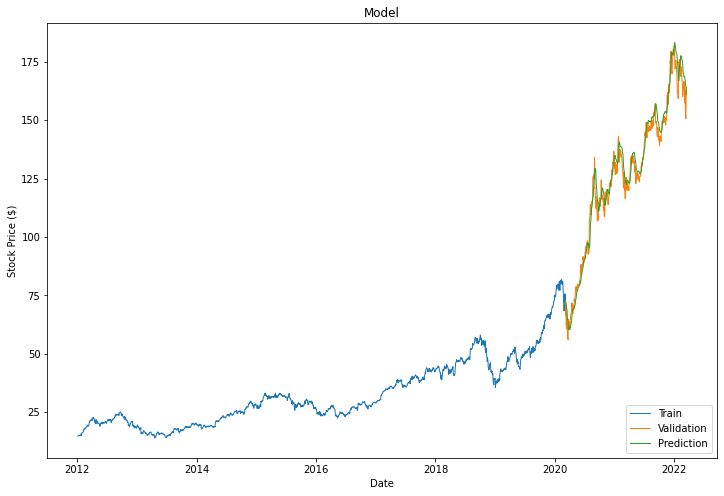

In [28]:
#plot the result
train=data[:train_data_len]
valid=data[train_data_len:]
valid=valid.assign(Predictions=predictions)
plt.figure(figsize=(12,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.plot(train['Close'], lw=1)
plt.plot(valid[['Close','Predictions']], lw=1)
plt.legend(['Train','Validation', 'Prediction'],loc='lower right')
plt.show()

In [29]:
valid

,Close,Predictions
Date,,
2020-03-06,72.257500,72.574974
2020-03-09,66.542503,72.518295
2020-03-10,71.334999,71.872658
2020-03-11,68.857498,71.448273
2020-03-12,62.057499,70.925476
...,...,...
2022-03-14,150.619995,164.412506
2022-03-15,155.089996,162.700195
2022-03-16,159.589996,161.396271


In [30]:
#get the quote
quote=web.DataReader('AAPL', 'yahoo', '2021-12-01', '2022-03-29')

In [31]:
quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-12-01,170.300003,164.529999,167.479996,164.770004,152052500.0,164.560349
2021-12-02,164.199997,157.800003,158.740005,163.759995,136739200.0,163.551620
2021-12-03,164.960007,159.720001,164.020004,161.839996,118023100.0,161.634064
2021-12-06,167.880005,164.279999,164.289993,165.320007,107497000.0,165.109650
2021-12-07,171.580002,168.339996,169.080002,171.179993,120405400.0,170.962173
...,...,...,...,...,...,...
2022-03-23,172.639999,167.649994,167.990005,170.210007,98062700.0,170.210007
2022-03-24,174.139999,170.210007,171.059998,174.070007,90131400.0,174.070007
2022-03-25,175.279999,172.750000,173.880005,174.720001,80470700.0,174.720001


In [32]:
quote_df=quote.filter(['Close'])

In [33]:
quote_df.shape

(82, 1)

In [34]:
quote_df

,Close
Date,
2021-12-01,164.770004
2021-12-02,163.759995
2021-12-03,161.839996
2021-12-06,165.320007
2021-12-07,171.179993
...,...
2022-03-23,170.210007
2022-03-24,174.070007
2022-03-25,174.720001


In [35]:
quote_df.tail(10)

,Close
Date,
2022-03-16,159.589996
2022-03-17,160.619995
2022-03-18,163.979996
2022-03-21,165.380005
2022-03-22,168.820007
2022-03-23,170.210007
2022-03-24,174.070007
2022-03-25,174.720001
2022-03-28,175.600006


In [36]:
#last 60 days
last_60_days=quote_df.values
#last_60_days
last_60_days_scaled=scaler.transform(last_60_days)


In [37]:
last_60_days_scaled.shape

(82, 1)

In [38]:
X_test=[]

for i in range(60, len(last_60_days_scaled)):
  X_test.append(last_60_days_scaled[i-60:i,0])

In [39]:
X_test=np.array(X_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [40]:
X_test.shape

(22, 60, 1)

In [41]:
predicted_price=model.predict(X_test)
predicted_prce=scaler.inverse_transform(predicted_price)
predicted_prce.shape

(22, 1)

In [42]:
print(predicted_prce)

[[169.93059]
 [169.29005]
 [168.6966 ]
 [168.589  ]
 [168.68779]
 [168.5519 ]
 [167.8969 ]
 [166.8495 ]
 [166.3246 ]
 [165.58101]
 [164.4125 ]
 [162.7002 ]
 [161.39629]
 [160.90134]
 [160.97523]
 [161.72803]
 [162.90915]
 [164.58675]
 [166.49652]
 [168.76823]
 [171.04828]
 [173.20007]]


In [43]:
predicted_prce_df = pd.DataFrame(predicted_prce, columns=['Predicted Price'])
predicted_prce_df = predicted_prce_df[-7:]
predicted_prce_df

,Predicted Price
15,161.728027
16,162.909149
17,164.586746
18,166.496521
19,168.768234
20,171.048279
21,173.200073


In [44]:
#get the quote
actual_price = web.DataReader('AAPL', 'yahoo', '2022-03-20', '2022-03-29')
actual_price

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-03-21,166.350006,163.009995,163.509995,165.380005,95811400,165.380005
2022-03-22,169.419998,164.910004,165.509995,168.820007,81532000,168.820007
2022-03-23,172.639999,167.649994,167.990005,170.210007,98062700,170.210007
2022-03-24,174.139999,170.210007,171.059998,174.070007,90131400,174.070007
2022-03-25,175.279999,172.750000,173.880005,174.720001,80470700,174.720001
2022-03-28,175.729996,172.000000,172.169998,175.600006,90371900,175.600006
2022-03-29,179.009995,176.339996,176.690002,178.960007,100589400,178.960007


In [45]:
price_diff = actual_price.filter(['Close'])
price_diff["Predicted Price"] = pd.NaT
price_diff["Predicted Price"] = np.array(predicted_prce_df)
price_diff["Price Difference"] = pd.NaT
price_diff["Price Difference"] = price_diff["Predicted Price"] - price_diff["Close"]
price_diff

,Close,Predicted Price,Price Difference
Date,,,
2022-03-21,165.380005,161.728027,-3.651978
2022-03-22,168.820007,162.909149,-5.910858
2022-03-23,170.210007,164.586746,-5.623260
2022-03-24,174.070007,166.496521,-7.573486
2022-03-25,174.720001,168.768234,-5.951767
2022-03-28,175.600006,171.048279,-4.551727
2022-03-29,178.960007,173.200073,-5.759933


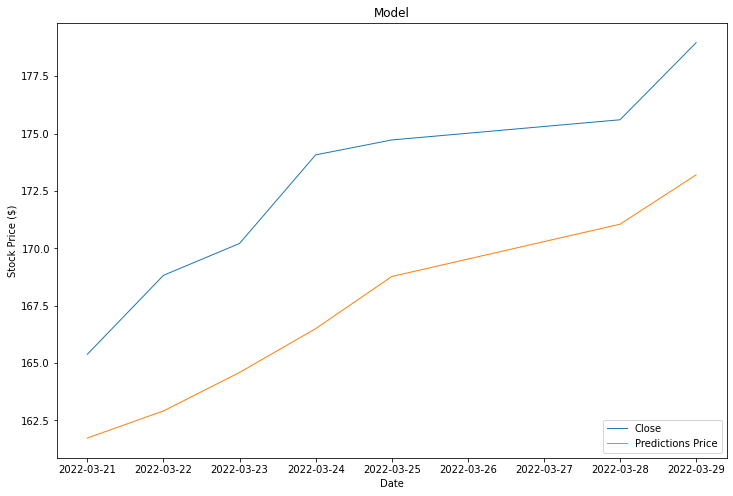

In [48]:
plt.figure(figsize=(12,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.plot(price_diff[['Close','Predicted Price']], lw=1)
plt.legend(['Close','Predictions Price'],loc='lower right')
plt.show()

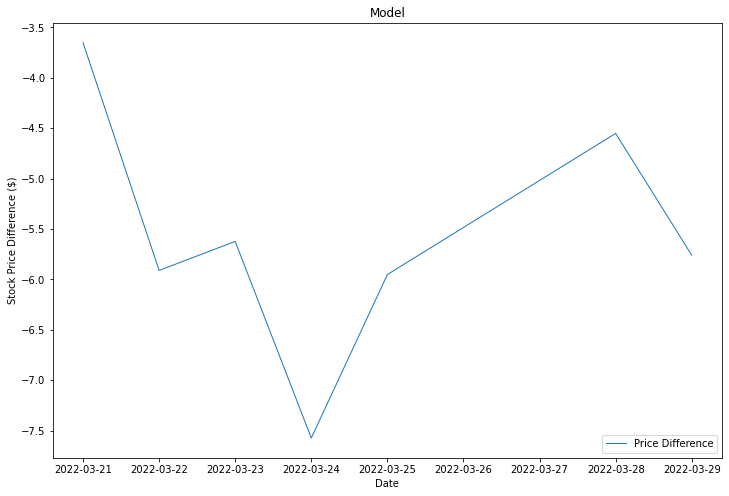

In [49]:
plt.figure(figsize=(12,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Stock Price Difference ($)')
plt.plot(price_diff[['Price Difference']], lw=1)
plt.legend(['Price Difference'],loc='lower right')
plt.show()